In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import FEATURES_DIR, RESULTS_DIR
from analyses.ridge_regression_decoding_mni_mmda import NUM_CV_SPLITS, REGRESSION_MODEL_PYTORCH, REGRESSION_MODEL_SKLEARN, HyperParameters, DISTANCE_METRICS

plt.style.use('seaborn-v0_8-deep')
from glob import glob
import pickle
from tqdm import tqdm

from notebook_utils import load_results_data

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_mode = "train"
regression_models = [REGRESSION_MODEL_PYTORCH, REGRESSION_MODEL_SKLEARN]
# subjects = ['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-07']
# subjects = ['sub-01', 'sub-02', 'sub-04']
subjects = ['sub-01', 'sub-02']

distance_metrics = ["cosine"]
all_data = load_results_data(training_mode, regression_models, distance_metrics, subjects)


In [3]:
def plot_val_metrics(data):
    metrics   = ['val_loss', f'val_acc_{distance_metric}', 'val_rsa']

    model_names_in_data = data.model.unique()
    fig, axes = plt.subplots(len(model_names_in_data), len(metrics), figsize=(len(metrics)*6, len(model_names_in_data)*4), squeeze=False)
    
    for row, model_name in enumerate(model_names_in_data):
        for col, metric in enumerate(metrics):
            legend = True if (col == len(metrics) - 1) else False
            data_filtered = data[(data.metric==metric) & (data.model == model_name)].dropna()
            sns.barplot(ax=axes[row,col], data=data_filtered, x="subject", y="value", hue="hp_str", legend=legend)
            if legend and len(data) > 0:
                sns.move_legend(axes[row,col], bbox_to_anchor=(1.1, 1.05), loc="upper left")
            axes[row,col].grid(alpha=0.5)
            axes[row,col].set_ylabel(f'{metric}')
            axes[row,col].set_title(f'{metric} | {model_name}')
            if "rsa" in metric:
                axes[row,col].set_ylim(bottom=0, top=0.2)
            elif metric == "val_loss":
                axes[row,col].set_ylim(bottom=0.8, top=1.0)
            else:
                axes[row,col].set_ylim(bottom=0.5, top=1)
    
    # fig.suptitle("Val Performance", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "val_performance.png"), dpi=300)



In [4]:
def plot_test_metrics(data):
    metrics   = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images', 'rsa']

    model_names_in_data = data.model.unique()
    fig, axes = plt.subplots(len(model_names_in_data), len(metrics), figsize=(len(metrics)*6, len(model_names_in_data)*4), squeeze=False)
    
    for row, model_name in enumerate(model_names_in_data):
        for col, metric in enumerate(metrics):
            legend = True if (col == len(metrics) - 1) else False
            data_filtered = data[(data.metric==metric) & (data.model == model_name)].dropna()
            sns.barplot(ax=axes[row,col], data=data_filtered, x="subject", y="value", hue="hp_str", legend=legend)
            if legend and len(data) > 0:
                sns.move_legend(axes[row,col], bbox_to_anchor=(1.1, 1.05), loc="upper left")
            axes[row,col].grid(alpha=0.5)
            axes[row,col].set_ylabel(f'{metric}')
            axes[row,col].set_title(f'{metric} | {model_name}')
            if "rsa" in metric:
                axes[row,col].set_ylim(bottom=0, top=0.25)
            elif metric == "val_loss":
                axes[row,col].set_ylim(bottom=0.9, top=1.0)
            else:
                axes[row,col].set_ylim(bottom=0.5, top=1)
    
    # fig.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "test_performance.png"), dpi=300)


## Pytorch Linear layer vs. sklearn

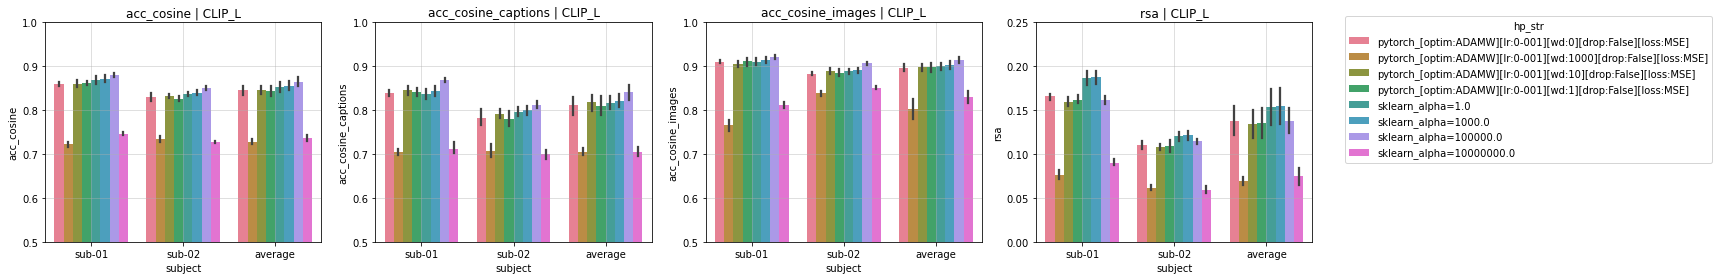

In [5]:
distance_metric  = 'cosine'

data_to_plot = all_data[all_data.model == "CLIP_L"]
data_to_plot = data_to_plot[data_to_plot.subject.isin(['sub-01', 'sub-02', 'average'])]

data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['pytorch_[optim:ADAMW][lr:0-001][wd:0][drop:False][loss:MSE]', 'pytorch_[optim:ADAMW][lr:0-001][wd:1][drop:False][loss:MSE]', 'pytorch_[optim:ADAMW][lr:0-001][wd:10][drop:False][loss:MSE]', 'pytorch_[optim:ADAMW][lr:0-001][wd:1000][drop:False][loss:MSE]', 'sklearn_alpha=1.0', 'sklearn_alpha=1000.0', 'sklearn_alpha=100000.0', 'sklearn_alpha=10000000.0'])]

plot_test_metrics(data_to_plot)

## Model selection based on val loss vs. val pairwise acc

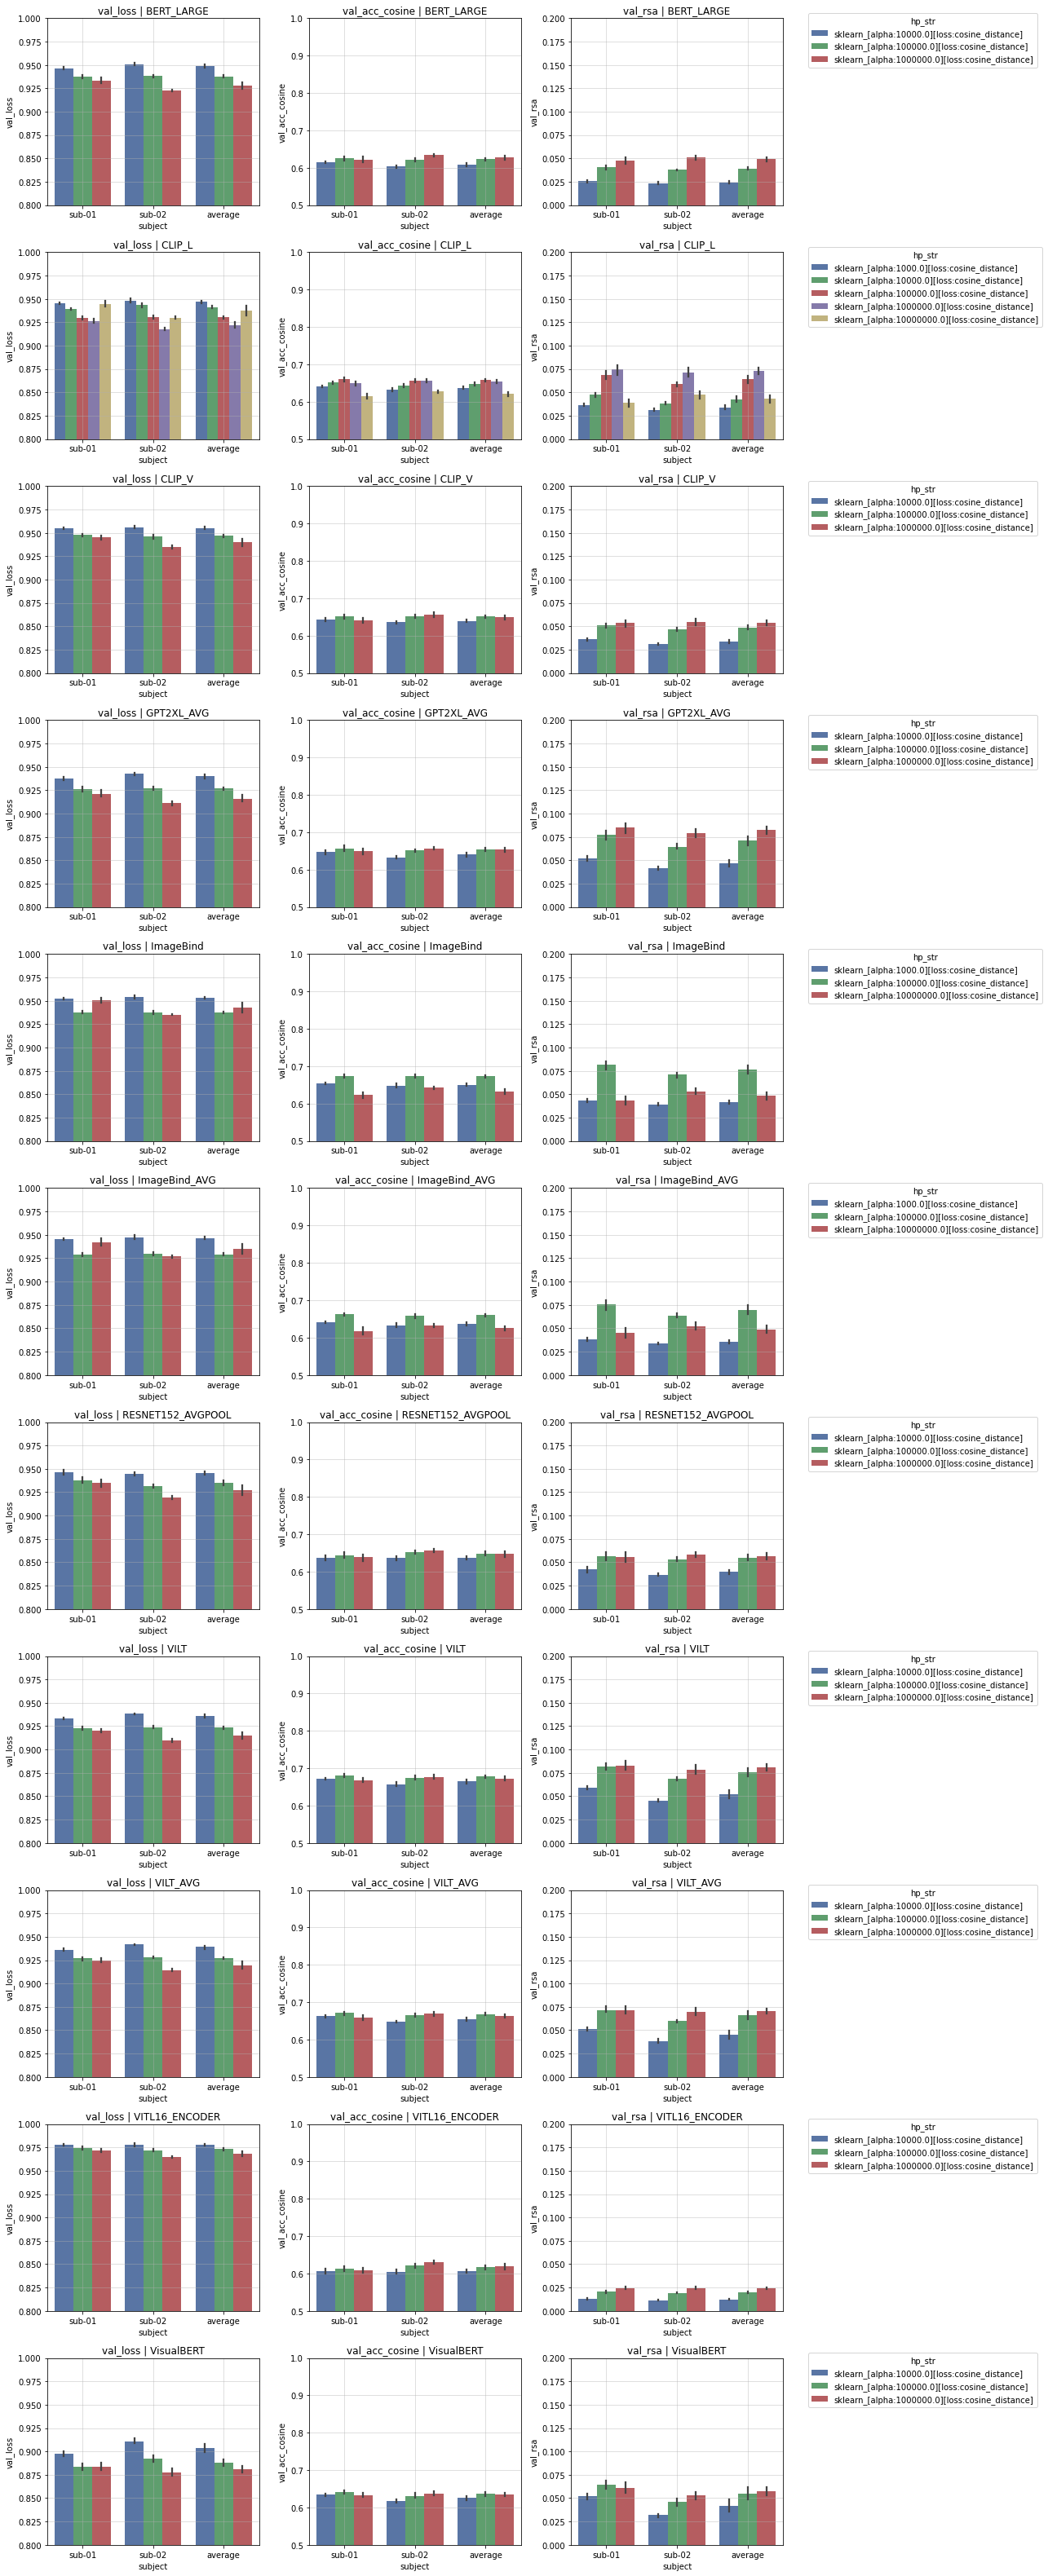

In [6]:
distance_metric  = 'cosine'

data_to_plot = all_data[all_data.regression_model == REGRESSION_MODEL_SKLEARN]
# data_to_plot = data_to_plot[data_to_plot.model.isin(['CLIP_L', 'VITL16_ENCODER', 'BERT_LARGE', 'GPT2XL_AVG'])]

# data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_alpha=1.0', 'sklearn_alpha=1000.0', 'sklearn_alpha=100000.0', 'sklearn_alpha=10000000.0'])]
# print(data_to_plot.hp_str.unique())
data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_[alpha:1000.0][loss:cosine_distance]', 'sklearn_[alpha:10000.0][loss:cosine_distance]', 'sklearn_[alpha:100000.0][loss:cosine_distance]', 'sklearn_[alpha:1000000.0][loss:cosine_distance]', 'sklearn_[alpha:10000000.0][loss:cosine_distance]'])]

# data_to_plot = all_data
plot_val_metrics(data_to_plot)


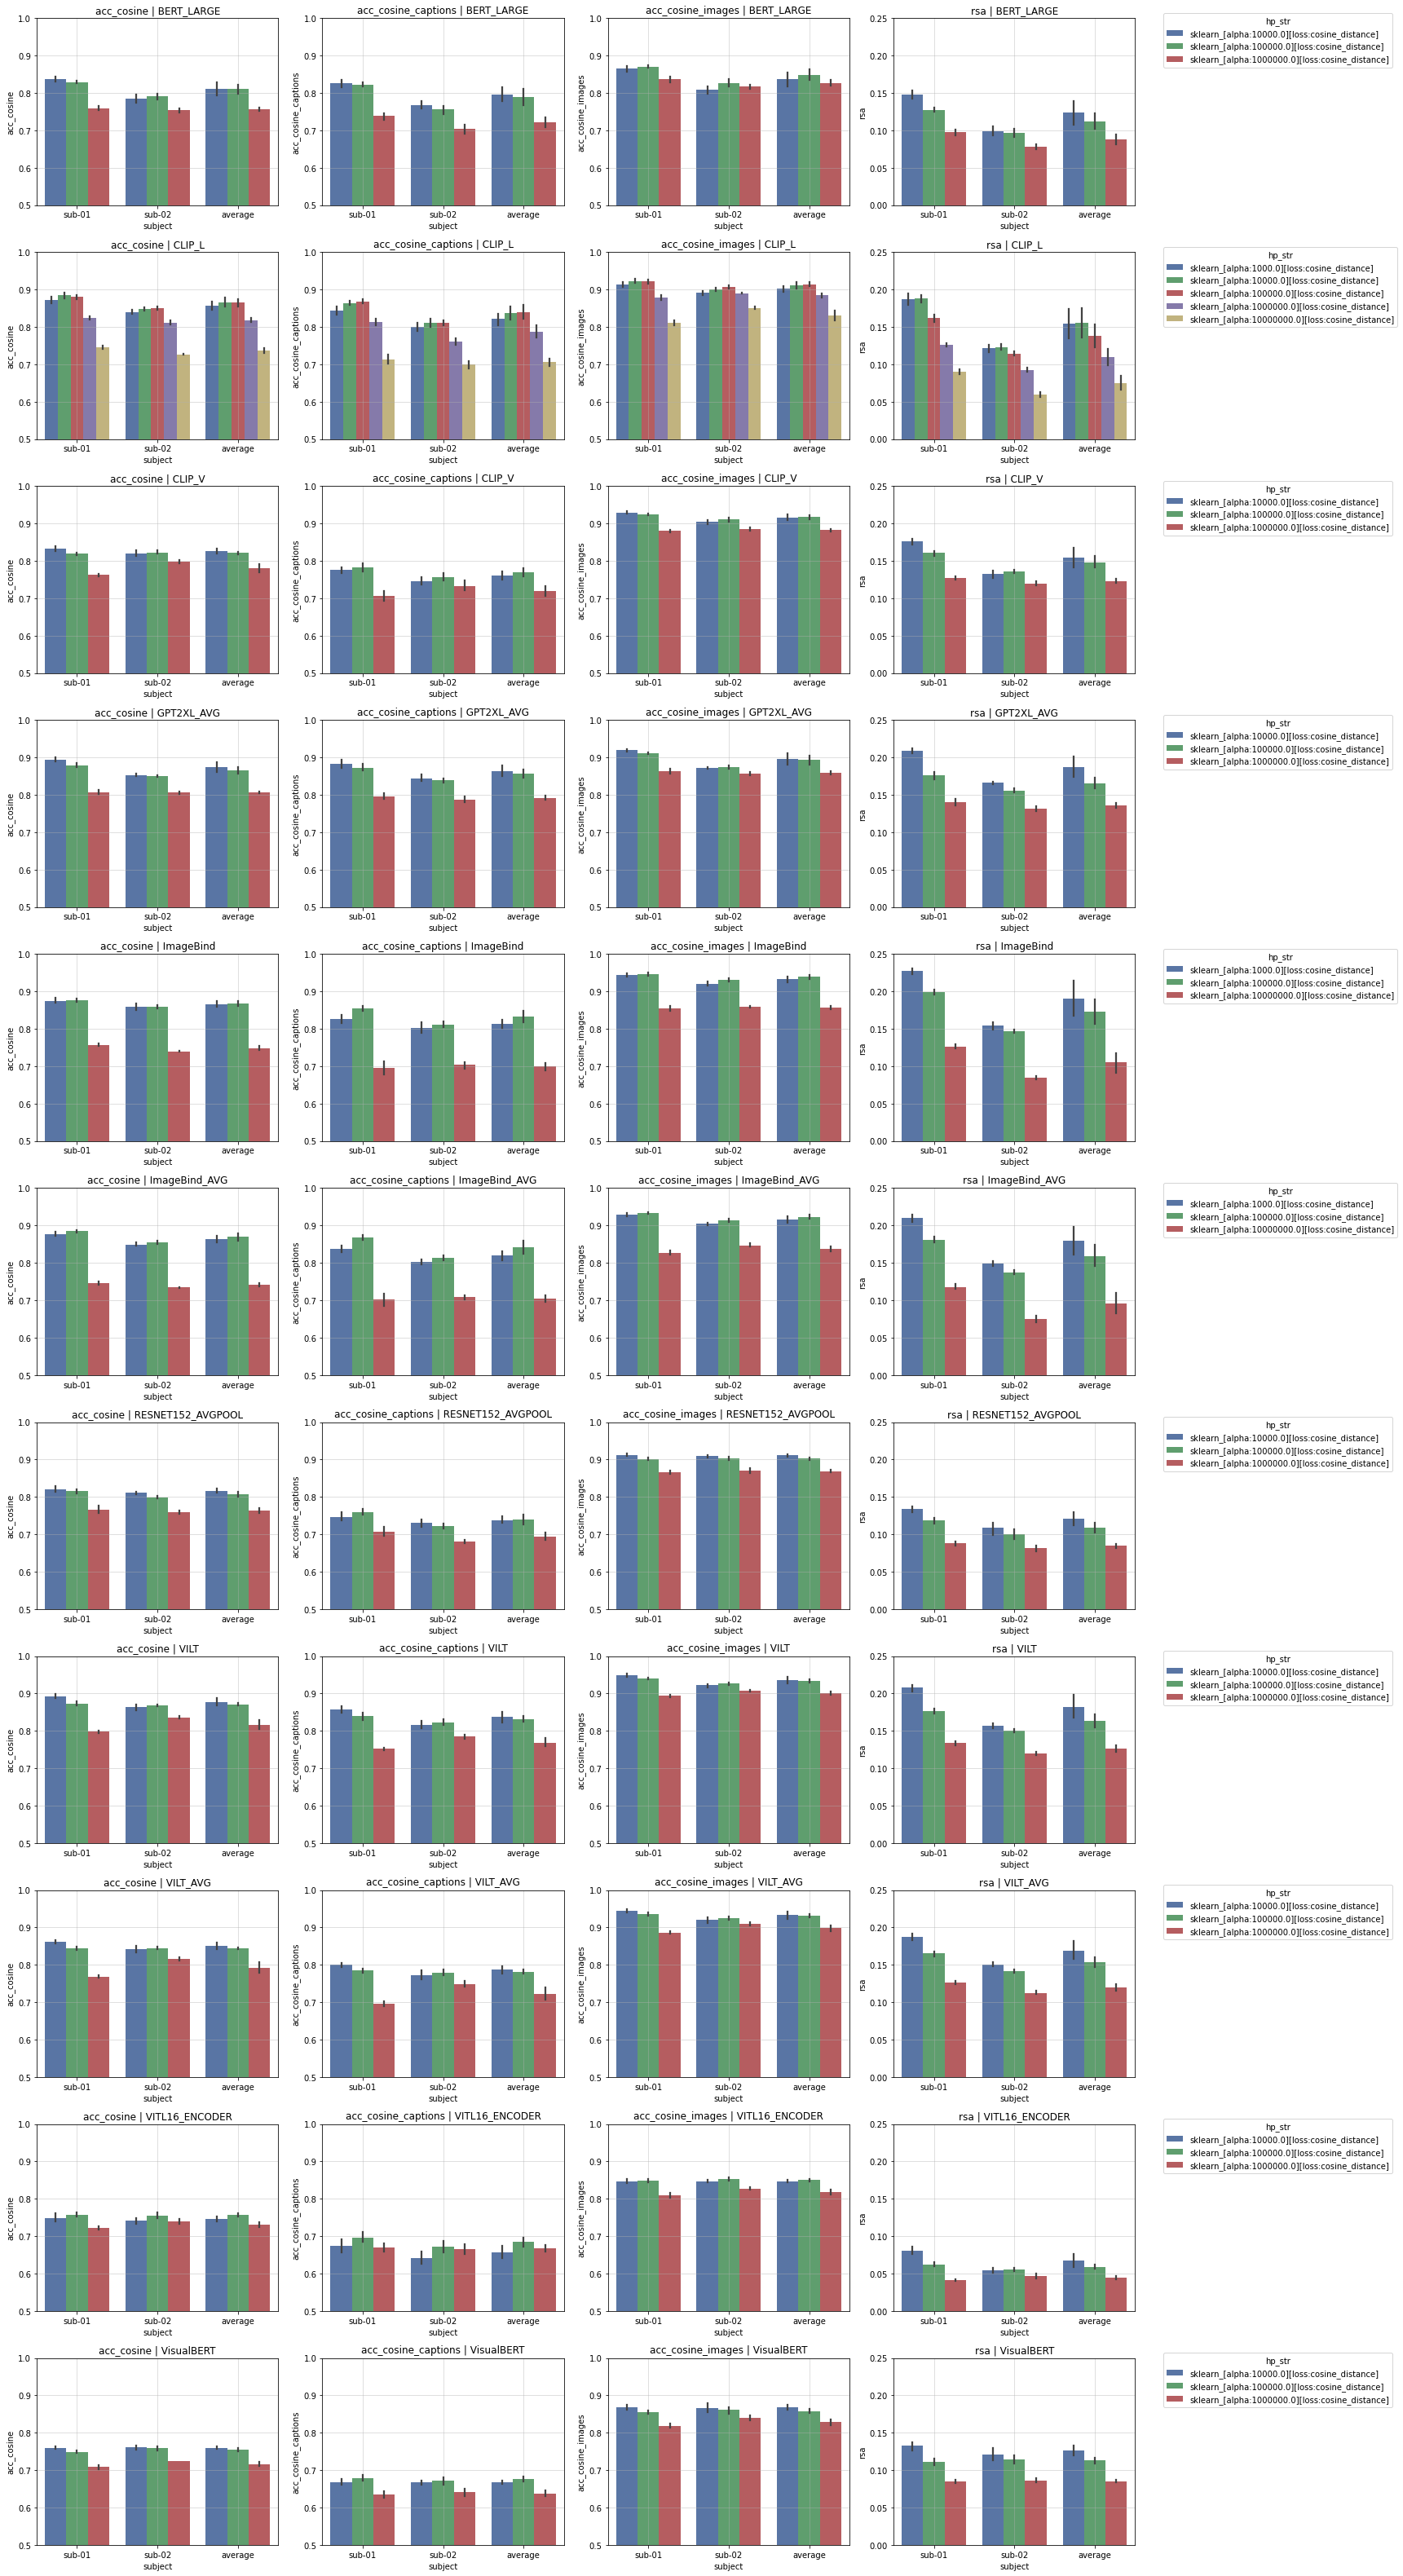

In [7]:
data_to_plot = all_data[all_data.regression_model == REGRESSION_MODEL_SKLEARN]
# print(data_to_plot.hp_str.unique())
# data_to_plot = data_to_plot[data_to_plot.model.isin(['CLIP_L', 'VITL16_ENCODER', 'BERT_LARGE', 'GPT2XL_AVG'])]

# data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_alpha=1.0', 'sklearn_alpha=1000.0', 'sklearn_alpha=100000.0', 'sklearn_alpha=10000000.0'])]
data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_[alpha:1000.0][loss:cosine_distance]', 'sklearn_[alpha:10000.0][loss:cosine_distance]', 'sklearn_[alpha:100000.0][loss:cosine_distance]', 'sklearn_[alpha:1000000.0][loss:cosine_distance]', 'sklearn_[alpha:10000000.0][loss:cosine_distance]'])]

# data_to_plot = all_data
plot_test_metrics(data_to_plot)

## Final training on full training set

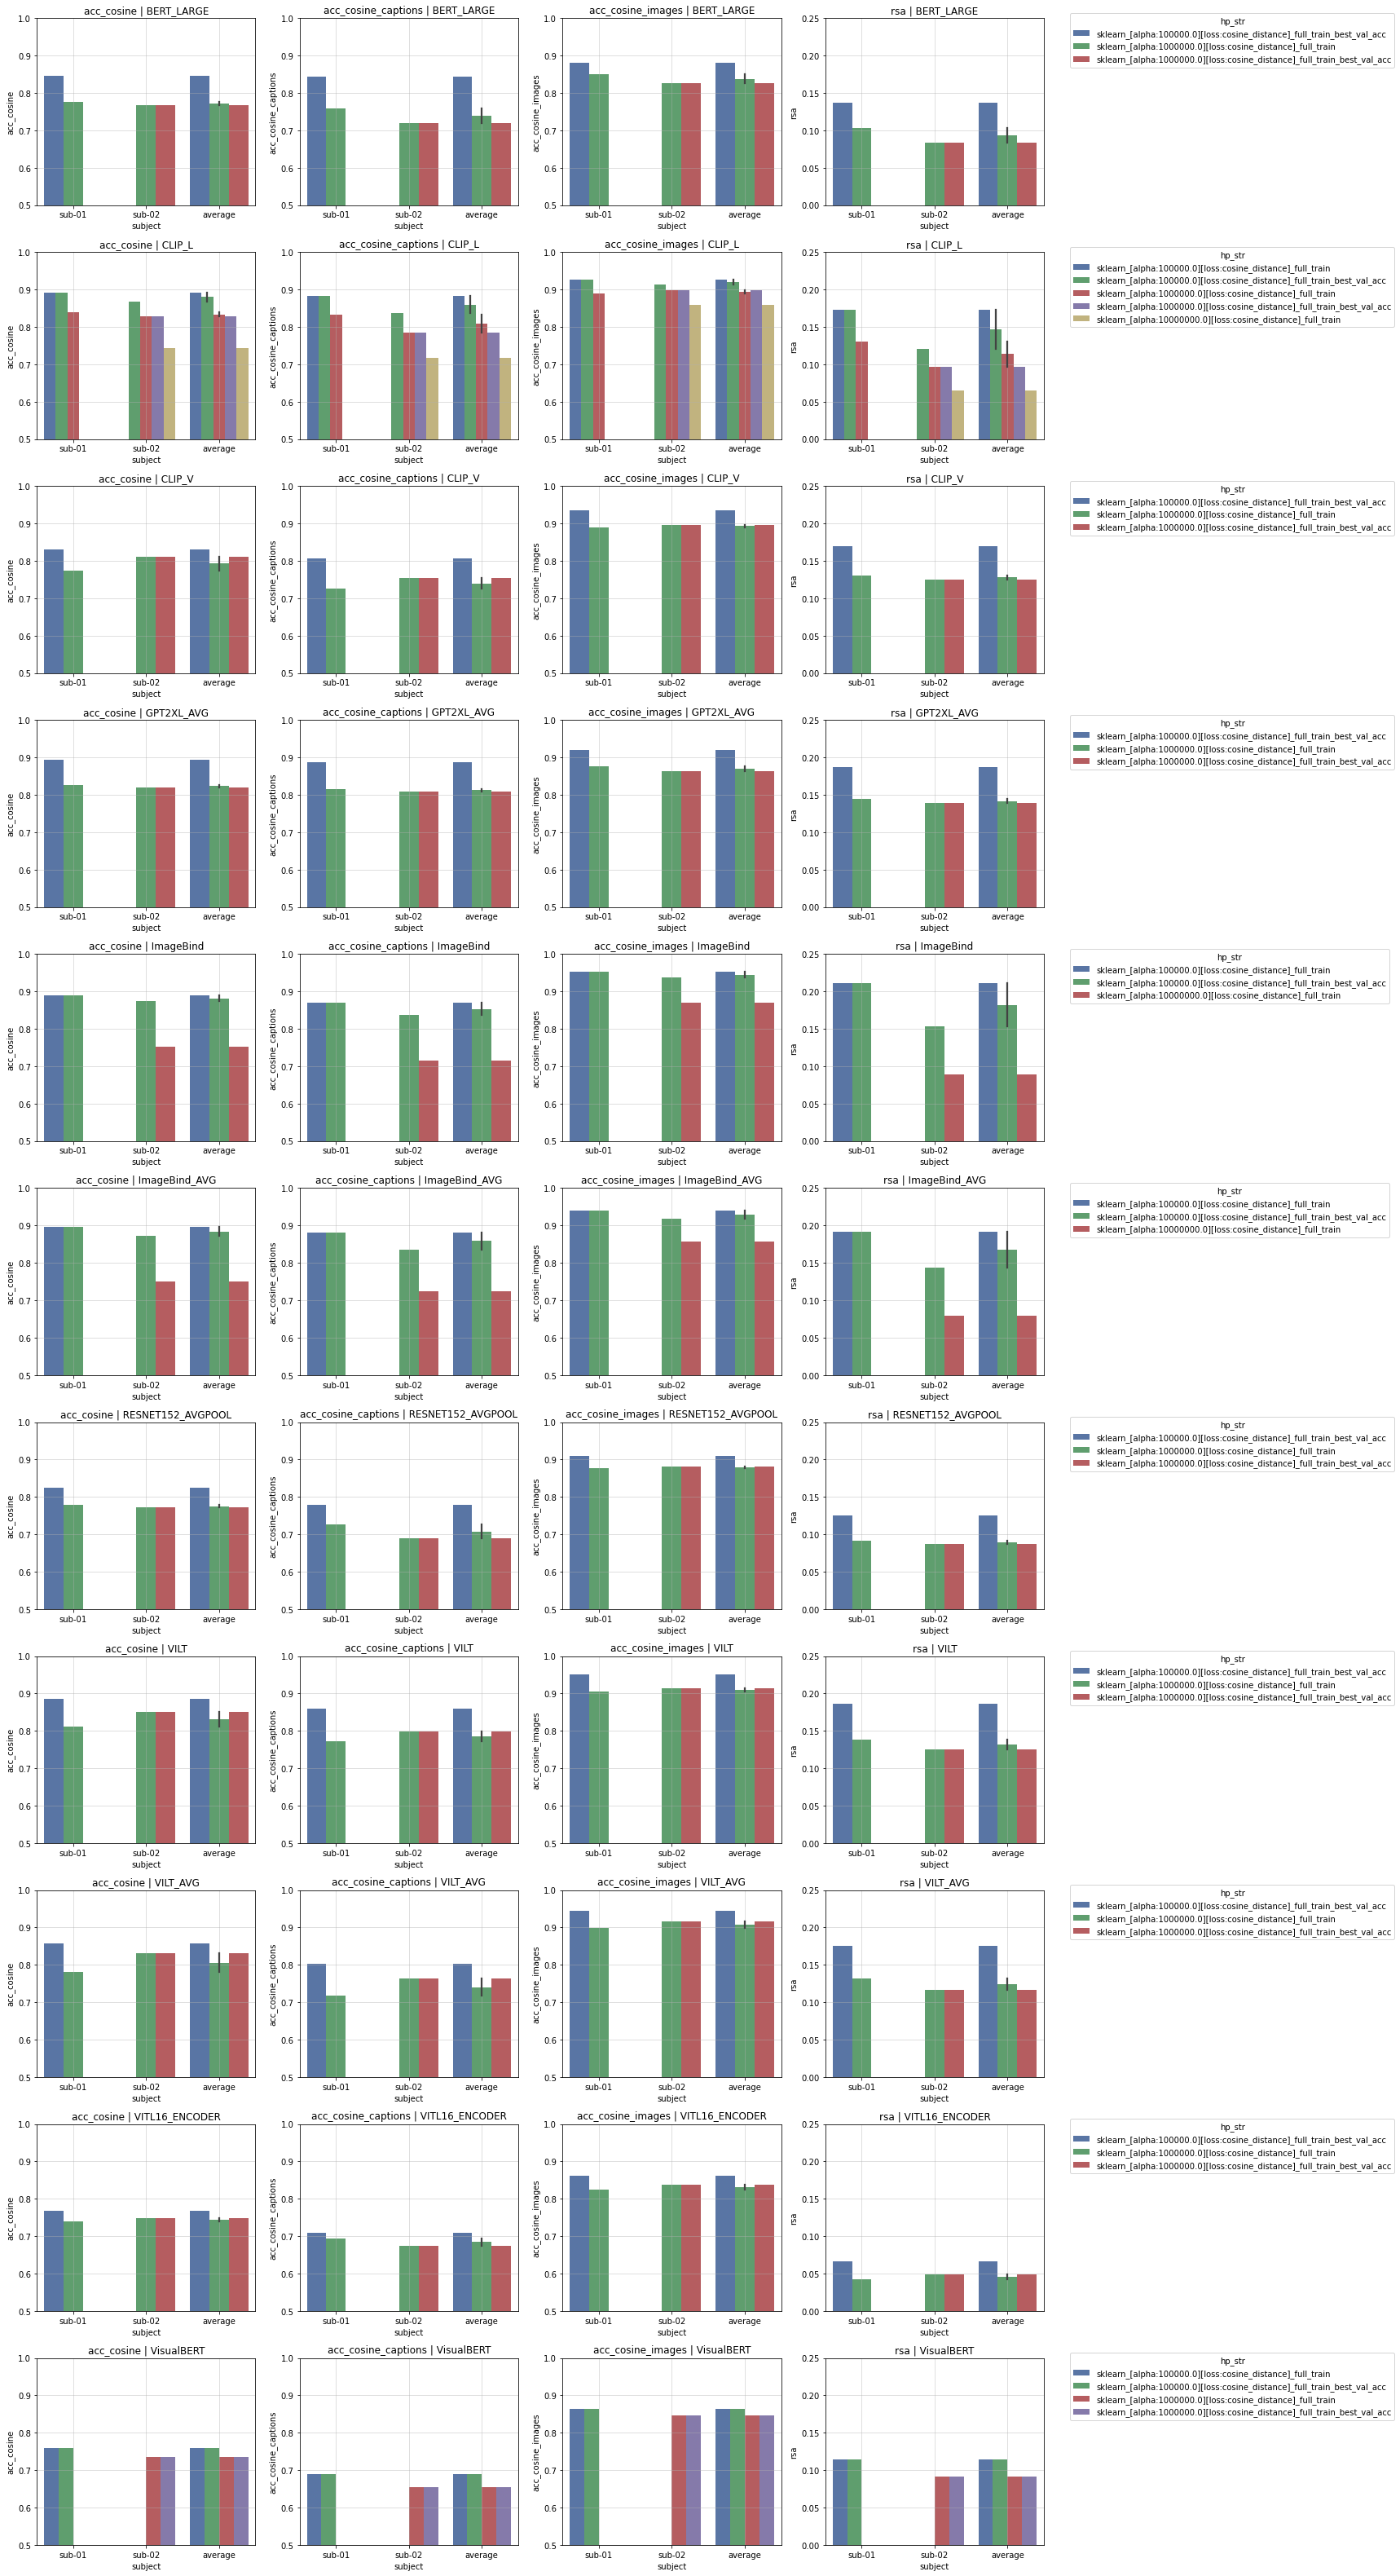

In [8]:
data_to_plot = all_data[all_data.regression_model == REGRESSION_MODEL_SKLEARN]
# print(data_to_plot.hp_str.unique())
# data_to_plot = data_to_plot[data_to_plot.model.isin(['CLIP_L', 'VITL16_ENCODER', 'BERT_LARGE', 'GPT2XL_AVG'])]
# data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_alpha=100000.0_full_train_best_val_acc', 'sklearn_alpha=10000000.0_full_train', 'sklearn_[alpha:100000.0][loss:cosine_distance]_full_train', 'sklearn_alpha=10000000.0'])]
# data_to_plot = data_to_plot[data_to_plot.hp_str.isin(['sklearn_[alpha:100000.0][loss:cosine_distance]_full_train_best_val_acc','sklearn_[alpha:100000.0][loss:cosine_distance]_full_train','sklearn_[alpha:1000000.0][loss:cosine_distance]_full_train', 'sklearn_[alpha:1000000.0][loss:cosine_distance]_full_train_best_val_acc', 'sklearn_[alpha:10000000.0][loss:cosine_distance]_full_train'])]
data_to_plot = data_to_plot[data_to_plot.hp_str.str.contains("full_train") & data_to_plot.hp_str.str.contains("loss:cosine_distance")]

# data_to_plot = all_data
plot_test_metrics(data_to_plot)

## 